# ARIMA

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Data

inventory = pd.read_csv('TradeInventories.csv', index_col='Date',parse_dates=True)
inventory.index.freq = 'MS'
inventory

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


[Text(0, 0.5, 'Chained 2012 Dollars')]

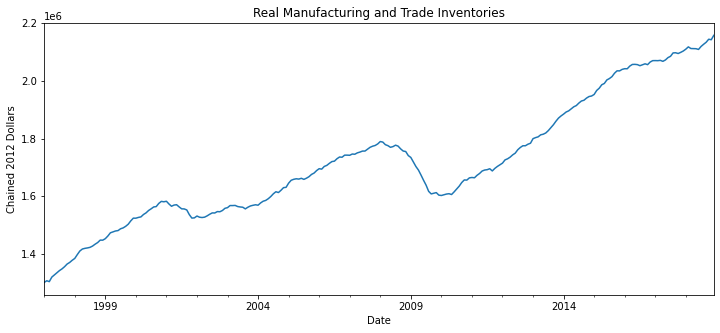

In [3]:
# Plot the Source Data

title = 'Real Manufacturing and Trade Inventories'
ylabel = 'Chained 2012 Dollars'

ax = inventory['Inventories'].plot(figsize = (12,5), title = title)
ax.autoscale(axis = 'x', tight = True)
ax.set(ylabel = ylabel)

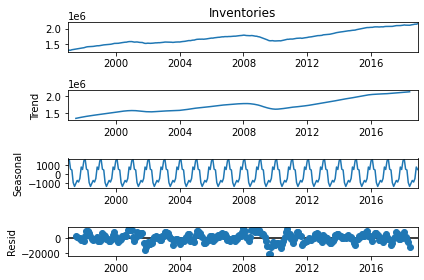

In [4]:
# ETS Decomposition (ETS) - Optional

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(inventory['Inventories'], model = 'add')
result.plot();

In [5]:
# Test for Stationarity (AD Fuller Test)
# TS is Non-Stationary

from statsmodels.tsa.stattools import adfuller

adfuller(inventory['Inventories'])

(-0.08768390982064546,
 0.9506515302298977,
 5,
 258,
 {'1%': -3.455952927706342,
  '10%': -2.572774990685656,
  '5%': -2.8728086526320302},
 4909.597979003463)

In [6]:
# Since the Data is Non-Stationary convert it to Stationary (De-Trending) via Differencing

from statsmodels.tsa.statespace.tools import diff
inventory['diff1'] = diff(inventory['Inventories'], k_diff = 1)
inventory

,Inventories,diff1
Date,,
1997-01-01,1301161,NaN
1997-02-01,1307080,5919.0
1997-03-01,1303978,-3102.0
1997-04-01,1319740,15762.0
1997-05-01,1327294,7554.0
...,...,...
2018-08-01,2127170,7552.0
2018-09-01,2134172,7002.0
2018-10-01,2144639,10467.0


In [7]:
new_inventory = inventory['diff1'].dropna() # Drop NANS for ADFULLER Testing
new_inventory

Date
1997-02-01     5919.0
1997-03-01    -3102.0
1997-04-01    15762.0
1997-05-01     7554.0
1997-06-01     7394.0
               ...   
2018-08-01     7552.0
2018-09-01     7002.0
2018-10-01    10467.0
2018-11-01    -1638.0
2018-12-01    15114.0
Freq: MS, Name: diff1, Length: 263, dtype: float64

In [8]:
adfuller(new_inventory) # The TS is now Stationary through Differencing of 1

(-3.412249391934807,
 0.010548311489190406,
 4,
 258,
 {'1%': -3.455952927706342,
  '10%': -2.572774990685656,
  '5%': -2.8728086526320302},
 4888.3029144158)

In [9]:
# Identify Orders (p, d, q) --> Trough ACF, PACF Graphs (Difficult)
# Identify Orders (p, d, q) --> Grid Search (pmdarima through auto_arima) (Easy)
# !pip install pmdarima

from pmdarima.arima import auto_arima

# StepWise Fitting

stepwise_fit = auto_arima(new_inventory, start_p = 0, start_q = 0, max_p = 2, max_q = 2, m = 12, seasonal = False, d = None, trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5409.215, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5264.999, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5327.280, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5248.721, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5232.025, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5231.279, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5231.745, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5311.328, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5228.127, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5225.667, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5229.374, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5235.724, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5234.707, Time=0.09 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 1.593 seconds


In [10]:
# ARIMA (1,1,1)

# Split Data Train/Test

# Set one year for testing

train = inventory.iloc[:252]
test = inventory.iloc[252:]

In [11]:
# Fit ARIMA Model

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()

In [12]:
# Obtain Predicted Values

start = len(train)
end = len(train) + len(test) + 1
predictions = results.predict(start = start, end = end, typ = 'levels').rename('ARIMA (1,1,1) Predictions')

[Text(0, 0.5, 'Chained 2012 Dollars')]

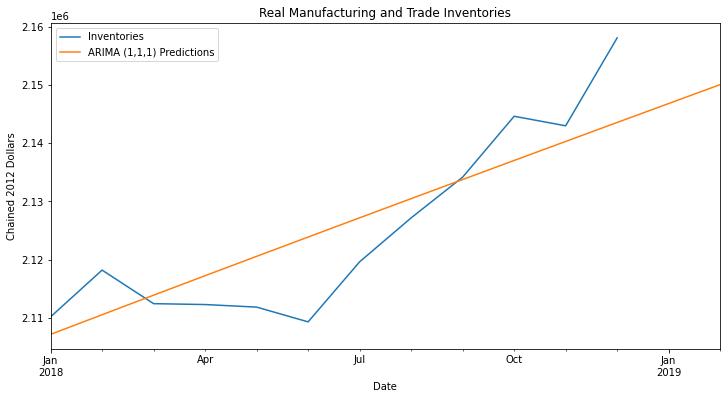

In [13]:
# Plot the Graph

title = 'Real Manufacturing and Trade Inventories'
ylabel = 'Chained 2012 Dollars'

ax = test['Inventories'].plot(legend = True, figsize = (12,6), title = title)
predictions.plot(legend = True)
ax.autoscale(axis = 'x', tight = True)
ax.set(ylabel = ylabel)

2019-01-01    2.165606e+06
2019-02-01    2.172709e+06
2019-03-01    2.179462e+06
2019-04-01    2.185897e+06
2019-05-01    2.192046e+06
2019-06-01    2.197936e+06
2019-07-01    2.203592e+06
2019-08-01    2.209036e+06
2019-09-01    2.214290e+06
2019-10-01    2.219371e+06
2019-11-01    2.224296e+06
2019-12-01    2.229079e+06
2020-01-01    2.233736e+06
Freq: MS, Name: ARIMA (1,1,1) Forecast, dtype: float64

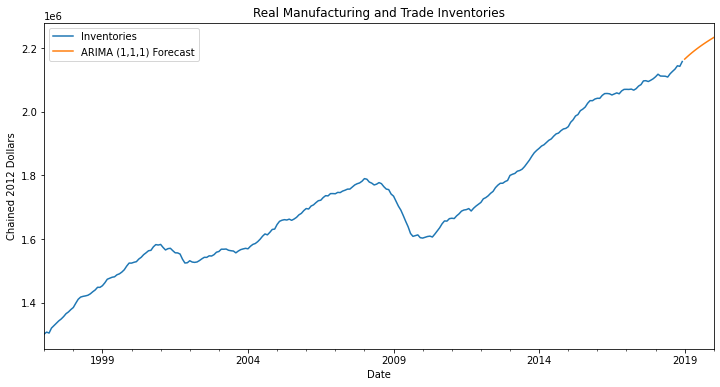

In [14]:
# Forecast (Retrained to whole dataset)

model = ARIMA(inventory['Inventories'], order = (1,1,1))
results = model.fit()
forecast = results.predict(start = len(inventory), end = len(inventory) + 12, typ = 'levels').rename('ARIMA (1,1,1) Forecast')

title = 'Real Manufacturing and Trade Inventories'
ylabel = 'Chained 2012 Dollars'

ax = inventory['Inventories'].plot(legend = True, figsize = (12,6), title = title)
forecast.plot(legend = True)
ax.autoscale(axis = 'x', tight = True)
ax.set(ylabel = ylabel)

forecast
